## Logistic VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example we have Poisson base distribution with Log Link function and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top} + \sigma_2 * I_{n}
$$

We run each scenario 100 times

In [1]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 2    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.1; 0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [1000; 10000; 50000]
ns = [5; 10; 20; 50]
nsims = 100

100

In [4]:
ENV["COLUMNS"] = 1000
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm100reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm100reps_sim.csv", ','))
fittimes = vec(readdlm("fittimesmultivariate_poisson_vcm100reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:2


1200-element Array{Float64,1}:
   1.956183848
   0.417137117
   0.198303812
   0.431122934
   0.464337046
   0.520886426
   0.418155846
   0.169592965
   0.824349661
   0.433090173
   0.633743248
   0.425546584
   0.440548948
   ⋮
 367.896505421
 143.708839163
 147.752784118
 142.910436497
 143.201870098
 142.396187402
 140.927511501
 142.593994649
 147.531563028
 141.634192394
 129.066533295
 144.680231778

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,0.405126,0.0199483,5000,0.385178,0.425074,8.10252e-5
2,1000,10,0.563762,0.0222564,10000,0.541506,0.586018,5.63762e-5
3,1000,20,0.897374,0.0364771,20000,0.860897,0.933851,4.48687e-5
4,1000,50,3.23446,0.131812,50000,3.10265,3.36627,6.46892e-5
5,10000,5,4.32734,0.128544,50000,4.19879,4.45588,8.65468e-5
6,10000,10,6.22946,0.183881,100000,6.04558,6.41334,6.22946e-5
7,10000,20,10.1774,0.366782,200000,9.81063,10.5442,5.0887e-5
8,10000,50,28.7172,0.879803,500000,27.8374,29.597,5.74344e-5
9,50000,5,28.4006,1.23513,250000,27.1655,29.6357,0.000113602


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


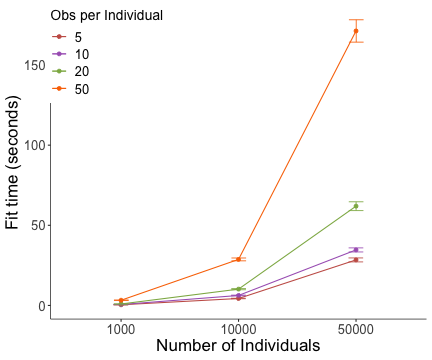

RObject{VecSxp}


In [6]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('5', '10', '20', '50'))
timedf$samplesize = factor(timedf$samplesize, levels = c('1000', '10000', '50000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


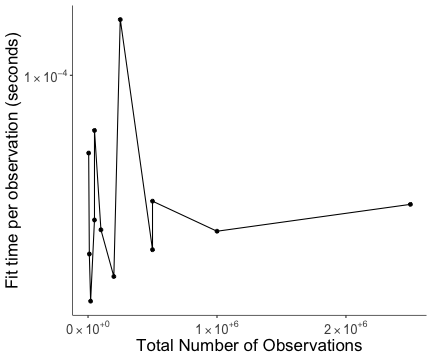

RObject{VecSxp}


In [7]:
using RCall
@rput timedf

R"""
library(scales)
library(ggplot2)
timedf$obssize <- factor(timedf$obssize, levels = c('5', '10', '20', '50'))
timedf$samplesize <- factor(timedf$samplesize, levels = c('1000', '10000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs = ggplot(timedf, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

"""

In [9]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_5betas_multivariate_poisson_vcm100reps_sim.csv", ',')
# samplesizes = collect(1000:1000:6000)
# ns = [10; 25; 50; 100; 1000]
# nsims = 1000

m = 2

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1,Σ2
,String,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 1000 ni: 5,"(0.59, 0.0494311)","(0.67, 0.0472582)","(0.65, 0.0479372)","(0.81, 0.0394277)","(0.93, 0.0256432)"
2,N: 1000 ni: 10,"(0.59, 0.0494311)","(0.64, 0.0482418)","(0.86, 0.0348735)","(0.76, 0.0429235)","(0.84, 0.0368453)"
3,N: 1000 ni: 20,"(0.53, 0.0501614)","(0.63, 0.0485237)","(0.69, 0.0464823)","(0.9, 0.0301511)","(0.62, 0.0487832)"
4,N: 1000 ni: 50,"(0.48, 0.0502117)","(0.6, 0.0492366)","(0.67, 0.0472582)","(0.78, 0.0416333)","(0.73, 0.0446196)"
5,N: 10000 ni: 5,"(0.55, 0.05)","(0.64, 0.0482418)","(0.67, 0.0472582)","(0.8, 0.0402015)","(0.81, 0.0394277)"
6,N: 10000 ni: 10,"(0.52, 0.0502117)","(0.66, 0.0476095)","(0.69, 0.0464823)","(0.69, 0.0464823)","(0.68, 0.0468826)"
7,N: 10000 ni: 20,"(0.51, 0.0502418)","(0.61, 0.0490207)","(0.76, 0.0429235)","(0.84, 0.0368453)","(0.45, 0.05)"
8,N: 10000 ni: 50,"(0.54, 0.0500908)","(0.52, 0.0502117)","(0.71, 0.0456048)","(0.72, 0.0451261)","(0.66, 0.0476095)"
9,N: 50000 ni: 5,"(0.47, 0.0501614)","(0.52, 0.0502117)","(0.68, 0.0468826)","(0.82, 0.0386123)","(0.75, 0.0435194)"


In [10]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_poisson_vcm100reps_sim.csv", ','))
ΣMseresult_1 = vec(readdlm("mse_Sigma_multivariate_poisson_vcm100reps_sim.csv", ','))
βΣcoverage_1 = readdlm("beta_sigma_coverage_5betas_multivariate_poisson_vcm100reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

# βMseresultnorm = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
# τMseresultnorm = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
# ΣMseresultnorm = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
# βτcoveragenorm = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')


# samplesizesnorm = collect(1000:1000:6000)
# nsnorm = [10; 25; 50; 100; 1000]
# nsimsnorm = 1000

p = 3; m = 2
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, Σmse = ΣMseresult_1, 
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

# p = 5; l = 5
# sample_sizesnorm = repeat(string.(samplesizesnorm), inner = nsimsnorm * length(nsnorm))
# obs_sizesnorm = repeat(string.(nsnorm), inner = nsimsnorm, outer = length(samplesizesnorm))
# msedfnorm = DataFrame(βmse = βMseresultnorm, τmse = τMseresultnorm, Σγmse = ΣMseresultnorm, 
#     samplesize = sample_sizesnorm, obssize = obs_sizesnorm)

#rename to make parsing easier for R.

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

# msedfnormR = deepcopy(msedfnorm)
# rename!(msedfnormR, ["betamse"
#     "taumse"
#     "Sigmamse"
#     "samplesize"
#  "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...) # ; repeat(msedfnormR[!, :obssize], 3)]

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) # ; repeat(msedfnormR[!, :samplesize], 3)]

parameters = collect([repeat(string.([:beta, :Sigma]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
# ; repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = collect([repeat(["Poisson with LogLink"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;
# repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.000132806,5,1000,beta,Poisson with LogLink
2,0.000429829,5,1000,beta,Poisson with LogLink
3,1.54084e-5,5,1000,beta,Poisson with LogLink
4,0.000148066,5,1000,beta,Poisson with LogLink
5,0.000105384,5,1000,beta,Poisson with LogLink
6,3.97394e-5,5,1000,beta,Poisson with LogLink
7,0.000657912,5,1000,beta,Poisson with LogLink
8,0.000915873,5,1000,beta,Poisson with LogLink
9,0.00158788,5,1000,beta,Poisson with LogLink


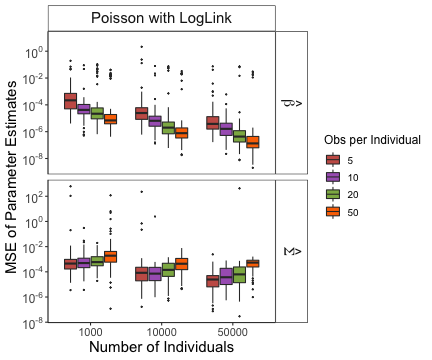

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('5', '10', '20', '50'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('1000', '10000', '50000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust = factor(msedfR$robust, levels = c('Poisson with LogLink'),
    labels = c(expression(paste("Poisson with LogLink")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('updated_msefacetplot_two_vcm_poisson.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_two_vcm_poisson.png"
